In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from eecs598.utils import reset_seed
from torchvision.utils import make_grid


# for plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

from ph1 import *
from helper import *
from load_cifar10 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.4.1
cuda


In [34]:
to_float= torch.float
to_long = torch.long
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [35]:
data_dir='./datasets'
loader_train, loader_val, loader_test = load_CIFAR10(data_dir, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


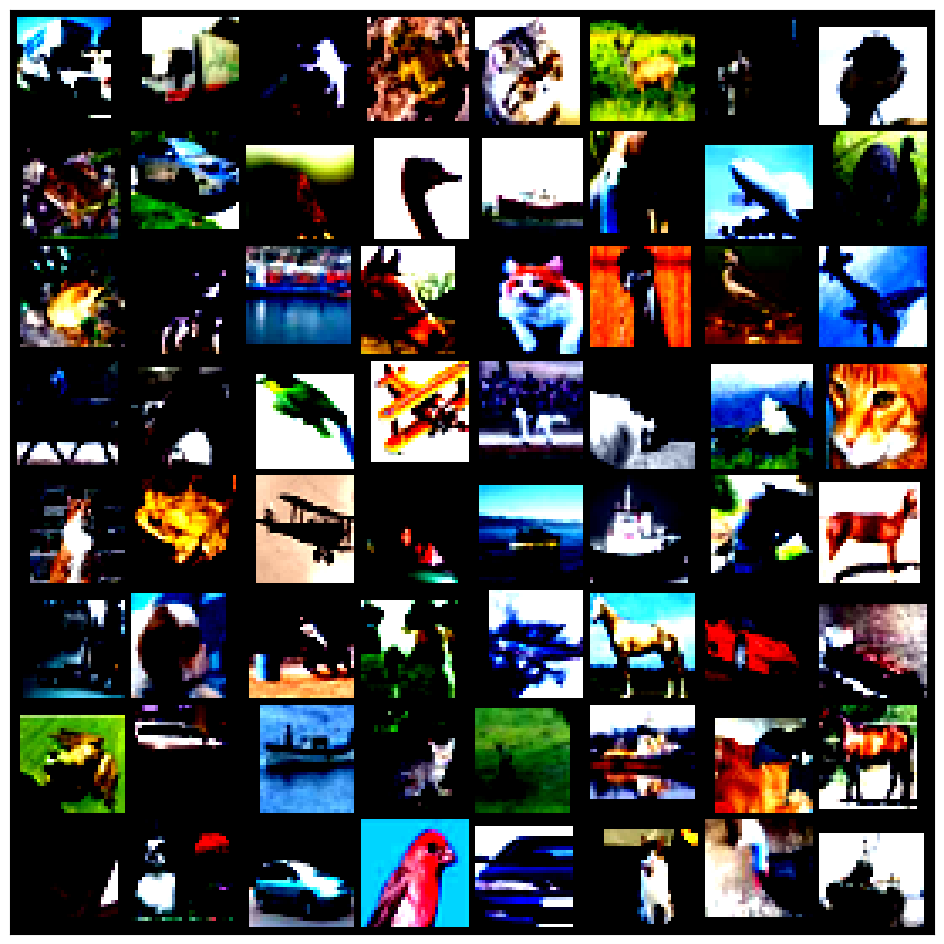

In [36]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(loader_train)

In [37]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd


def check_accuracy_part34(loader, model):
  print('Checking accuracy on validation set')
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=to_long)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc


def train_part345(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  print_every = 100
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=to_float)
  iter_history = torch.zeros(num_prints, dtype=to_long)
  for e in range(epochs):
    
    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=to_long)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

In [38]:
# example of specifications
networks = {
  'resnet44': { # acc=86%
    'block': ResidualBlock,
    'stage_args': [
      (64, 64, 5, False),  # Use 7 residual blocks in this stage
      (64, 128, 5, True),
      (128, 256, 5, True),
      (256, 512, 5, True),
    ]
  },
  'wideresnet': { # acc=86.2%
    'block': ResidualBlock,
    'stage_args': [
        (16, 32, 3, False),  # Double the channels
        (32, 64, 3, True),
        (64, 128, 3, True),
    ]
  },
    'resnet9k': { # acc=86.8%
        'block': ResidualBlock, 
        'stage_args': [
            (64, 64, 1, False),  
            (64, 128, 1, True),  
            (128, 256, 2, True), 
            (256, 512, 2, True), 
        ]
    }
}

def get_resnet(name):
  # YOUR_TURN: Impelement ResNet.__init__ and ResNet.forward
  return ResNet(**networks[name])

In [39]:

names = ['resnet44']
if os.path.exists('best.pth'):
  model = get_resnet(names[0]).to(device) 
  state_dict = torch.load('best.pth')
  model.load_state_dict(state_dict)
  check_accuracy_part34(loader_test, model)
else:
  acc_history_dict = {}
  iter_history_dict = {}
  for name in names:
    reset_seed(0)
    print(name, '\n')
    model = get_resnet(name)
    
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=.9, weight_decay=1e-4)

    acc_history, iter_history = train_part345(model, optimizer, epochs=20, schedule=[6, 15], verbose=False)
    acc_history_dict[name] = acc_history
    iter_history_dict[name] = iter_history
    torch.save(model.state_dict(), 'best.pth')

Checking accuracy on validation set


/tmp/ipykernel_29330/1927571075.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('best.pth')


Got 8799 / 10000 correct (87.99)
